## Loading Data and Packages

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from itertools import combinations

# Linear models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from statsmodels.api import OLS, add_constant
import statsmodels.formula.api as smf

# Noamlity test
from scipy.stats import normaltest

# Other models
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor


from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split

# Regression metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# test multi colinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
# Set plotting style
sns.set_style("darkgrid")
colors_cmap = sns.color_palette("mako", as_cmap=True)
colors = sns.color_palette("mako")

In [ ]:
# read data
data = pd.read_csv('Barcelona.csv', encoding='utf-8')

## Explatory Analysis

In [ ]:
shape_before_transformation = data.shape

In [ ]:
# data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            2995 non-null   object 
 1   host_since                      2996 non-null   object 
 2   host_response_time              2150 non-null   object 
 3   host_response_rate              2150 non-null   float64
 4   host_acceptance_rate            2163 non-null   float64
 5   host_is_superhost               2996 non-null   object 
 6   host_listings_count             2996 non-null   float64
 7   host_total_listings_count       2996 non-null   float64
 8   host_has_profile_pic            2996 non-null   object 
 9   host_identity_verified          2996 non-null   object 
 10  room_type                       3000 non-null   object 
 11  accommodates                    3000 non-null   int64  
 12  bedrooms                        29

In [ ]:
# how many missing value each feature has
missing_values = pd.DataFrame(data.isna().sum(), columns=['count_na'])
missing_values

,count_na
name,5
host_since,4
host_response_time,850
host_response_rate,850
host_acceptance_rate,837
host_is_superhost,4
host_listings_count,4
host_total_listings_count,4
host_has_profile_pic,4
host_identity_verified,4


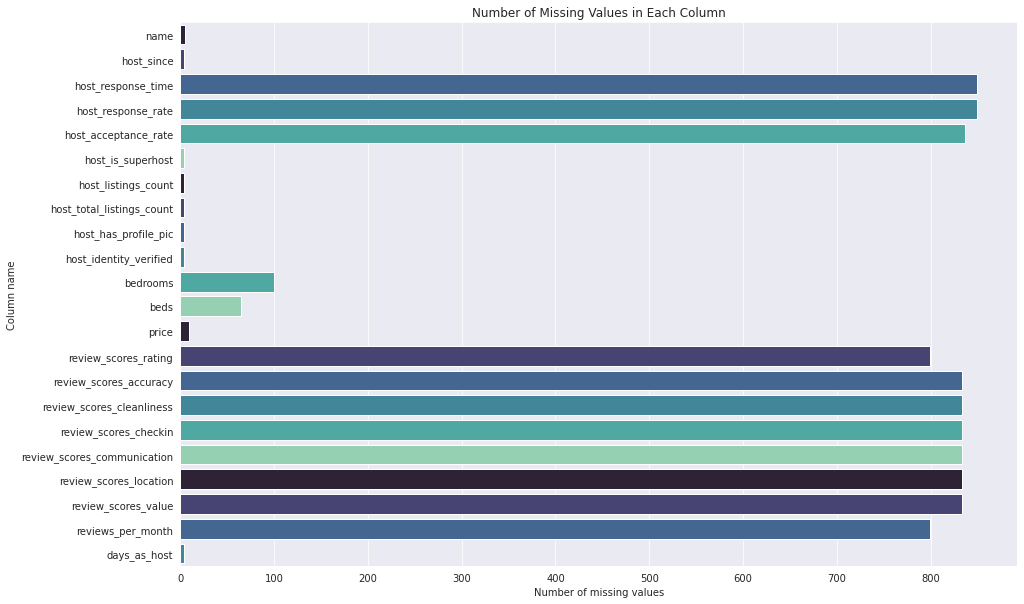

In [ ]:
plt.figure( figsize=(15,10) )
sns.barplot(
    x='count_na',
    y='index',
    data=missing_values.loc[missing_values['count_na'] > 0].reset_index(),
    orient='horizantal',
    palette=colors
)
plt.xlabel('Number of missing values')
plt.ylabel('Column name')
plt.title('Number of Missing Values in Each Column')
plt.show()

## Processing data type

In [ ]:
def get_data_type():
    t1 = data.select_dtypes(include='object').columns.tolist()
    t2 = data.select_dtypes(exclude='object').columns.tolist()
    return t1, t2

object_columns, nummeric_columns = get_data_type()

In [ ]:
# sampleing non numerical features to process

for c in object_columns:
    print(c.ljust(25," "), f"{missing_values.loc[c, 'count_na']}".rjust(3, " "), [ _ for _ in data.loc[0:1, c]])

name                        5 ['*monthly stays* nice apartment 3 rooms', 'Barcelona - Mobile World Congress']
host_since                  4 ['2011-11-16', '2013-10-13']
host_response_time        850 ['within an hour', nan]
host_is_superhost           4 ['f', 'f']
host_has_profile_pic        4 ['t', 't']
host_identity_verified      4 ['t', 't']
room_type                   0 ['Entire home/apt', 'Private room']
instant_bookable            0 ['t', 'f']
city                        0 ['Barcelona', 'Barcelona']


In [ ]:
data[object_columns].sample(3)

,name,host_since,host_response_time,host_is_superhost,host_has_profile_pic,host_identity_verified,room_type,instant_bookable,city
964,APARTM. TO 20 min-pl Cataluña-Ramblas-BARNA CITY,2020-01-22,within a few hours,f,t,f,Entire home/apt,f,Barcelona
703,"BEACH ,ATTIC APARTMENT TERRACE !",2012-07-24,NaN,f,t,t,Entire home/apt,f,Barcelona
1469,OFERTA Parc Güell Ideal teletrabajo y familias,2013-10-01,NaN,f,t,t,Entire home/apt,t,Barcelona


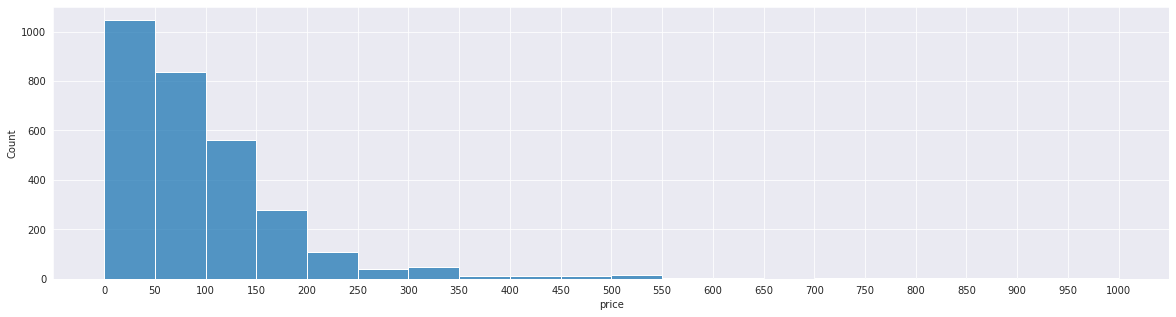

In [ ]:
plt.figure( figsize=(20,5))
hue_order = data['room_type'].value_counts().sort_values(ascending=False).index.tolist()
bins = [*range(0, 1001, 50)]
ax = sns.histplot(data=data, x='price', bins=bins)
plt.xticks(bins)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


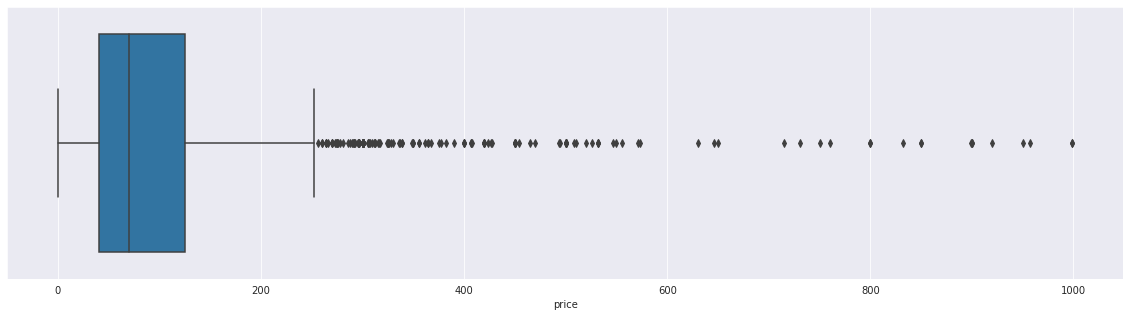

In [ ]:
plt.figure( figsize=(20,5) )
sns.boxplot(data['price'])
plt.show()

In [ ]:
data_large_price = data.loc[ data['price'] > 250].copy()

In [ ]:
f"% Percentage of removed data: {np.round(data_large_price.shape[0] / data.shape[0], 2)}"

'% Percentage of removed data: 0.05'

In [ ]:
data = data.loc[ data['price'] <= 250].copy()

In [ ]:
# drop columns with huge missing values
data.drop(missing_values.loc[ missing_values['count_na'] > 100 ].index.tolist(), axis=1, inplace=True)

In [ ]:
# fill NA for beds and bedrooms, it is likely to be the median
data['beds'].fillna(data['beds'].median(), inplace=True)
data['bedrooms'].fillna(data['bedrooms'].median(), inplace=True)

print('beds:', data['beds'].median(), data['beds'].mean())
print('bedrooms:', data['bedrooms'].median(), data['bedrooms'].mean())

beds: 2.0 2.2145121521662556
bedrooms: 1.0 1.5808383233532934


In [ ]:
object_columns, nummeric_columns = get_data_type()

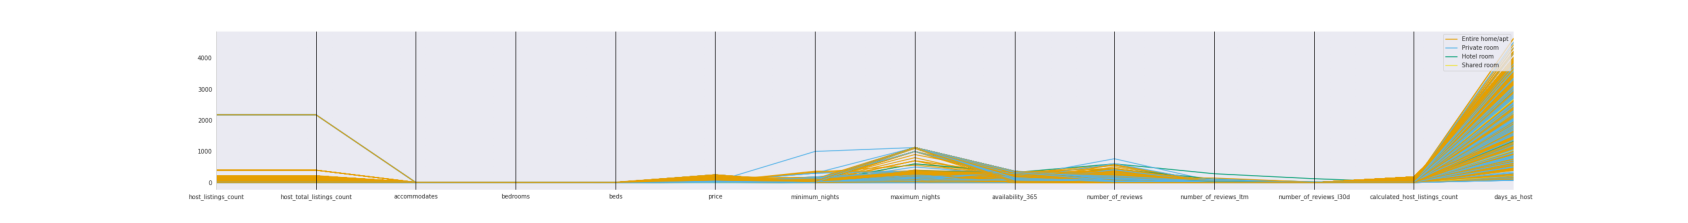

In [ ]:
# Important - apx 4 min to run

# pd.plotting.parallel_coordinates(data[nummeric_columns+['room_type']], class_column='room_type', color=("#E69F00", "#56B4E9", "#009E73", "#F0E442"))
# plt.savefig("./parallel_coordinates.png", format='png')

if os.path.isfile('./parallel_coordinates.png'):
    plt.figure( figsize=(30,5))
    img = mpimg.imread('./parallel_coordinates.png')
    plt.axis(False)
    imgplot = plt.imshow(img)
    plt.show()

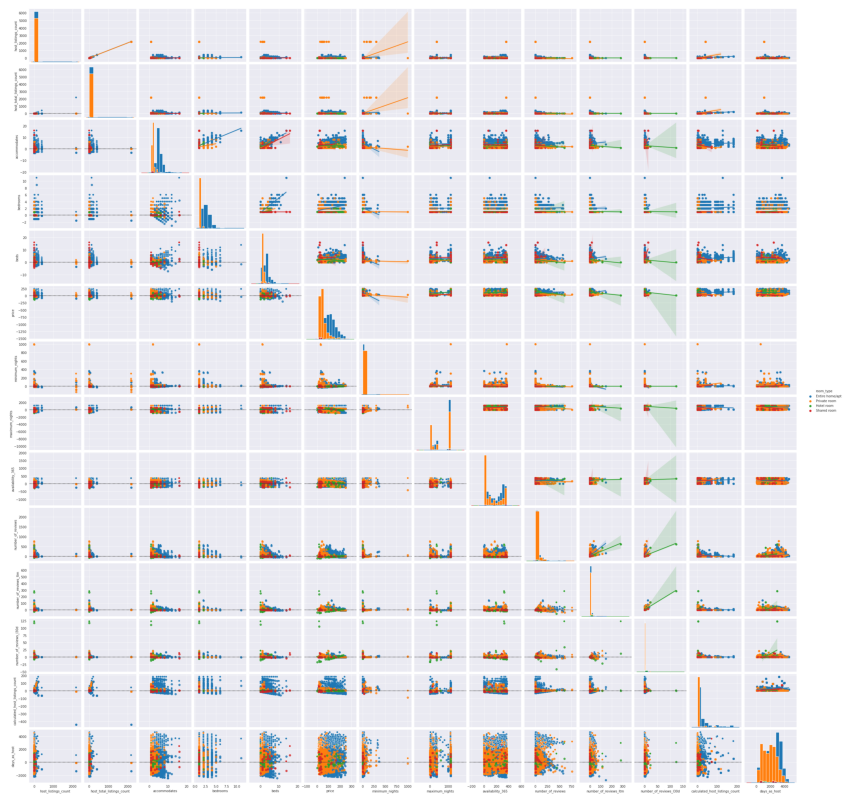

In [ ]:
# Important - apx 10 min to run

# axs = sns.pairplot(data[nummeric_columns+['room_type']], hue='room_type')

# axs.map_upper(sns.regplot)
# axs.map_lower(sns.residplot)
# axs.map_diag(plt.hist)
# axs.set(alpha=0.5)

# axs.savefig("./pairplot_nummeric.png", format='png')


if os.path.isfile('./pairplot_nummeric.png'):
    plt.figure( figsize=(15,15))
    img = mpimg.imread('./pairplot_nummeric.png')
    plt.axis(False)
    imgplot = plt.imshow(img)
    plt.show()

In [ ]:
missing_values = pd.DataFrame(data.isna().sum(), columns=['count_na'])

filter = (missing_values['count_na'] <= 10) & (missing_values['count_na'] != 0)
missing_values.loc[ filter ]

,count_na
name,5
host_since,4
host_is_superhost,4
host_listings_count,4
host_total_listings_count,4
host_has_profile_pic,4
host_identity_verified,4
days_as_host,4


In [ ]:
# drop missing rows
data.dropna(axis=0, how='any', inplace=True)

In [ ]:
# drop unneeded text columns
data.drop(['name', 'city', 'host_since'], axis=1, inplace=True)

In [ ]:
# convert binary columns to 1 if true and 0 if false
temp = ['host_is_superhost', 'host_has_profile_pic',
        'host_identity_verified', 'instant_bookable']
data[temp] = data[temp].replace(['t', 'f'], [1, 0])

In [ ]:
object_columns, nummeric_columns = get_data_type()
object_columns

['room_type']

In [ ]:
data = pd.concat([data, pd.get_dummies(data['room_type'], drop_first=True)], axis=1)
data.drop('room_type', axis=1, inplace=True)

In [ ]:
object_columns, nummeric_columns = get_data_type()
object_columns

[]

In [ ]:
data.rename({'Hotel room':'hotel_room'}, inplace=True, axis='columns')
data.rename({'Private room':'private_room'}, inplace=True, axis='columns')
data.rename({'Shared room':'shared_room'}, inplace=True, axis='columns')

In [ ]:
data.shape, shape_before_transformation

((2830, 21), (3000, 33))

In [ ]:
data_summary = data.describe().T
data_summary

,count,mean,std,min,25%,50%,75%,max
host_is_superhost,2830.0,0.162191,0.368691,0.0,0.00,0.0,0.00,1.0
host_listings_count,2830.0,30.691873,152.970118,0.0,1.00,3.0,15.75,2178.0
host_total_listings_count,2830.0,30.691873,152.970118,0.0,1.00,3.0,15.75,2178.0
host_has_profile_pic,2830.0,0.995406,0.067632,0.0,1.00,1.0,1.00,1.0
host_identity_verified,2830.0,0.782332,0.412733,0.0,1.00,1.0,1.00,1.0
accommodates,2830.0,3.267491,1.997746,1.0,2.00,2.0,4.00,16.0
bedrooms,2830.0,1.580212,0.884111,1.0,1.00,1.0,2.00,11.0
beds,2830.0,2.211661,1.652811,0.0,1.00,2.0,3.00,16.0
price,2830.0,82.248410,54.166705,0.0,39.00,66.0,117.00,250.0
minimum_nights,2830.0,12.764664,30.236906,1.0,1.00,3.0,30.00,1000.0


In [ ]:
rank_matrix = np.linalg.matrix_rank(data.drop(['price'], axis=1))
'Full rank Matrix:' , rank_matrix == data.shape[1]-1

('Full rank Matrix:', False)

# Correlation

In [ ]:
data_corr = data.corr()

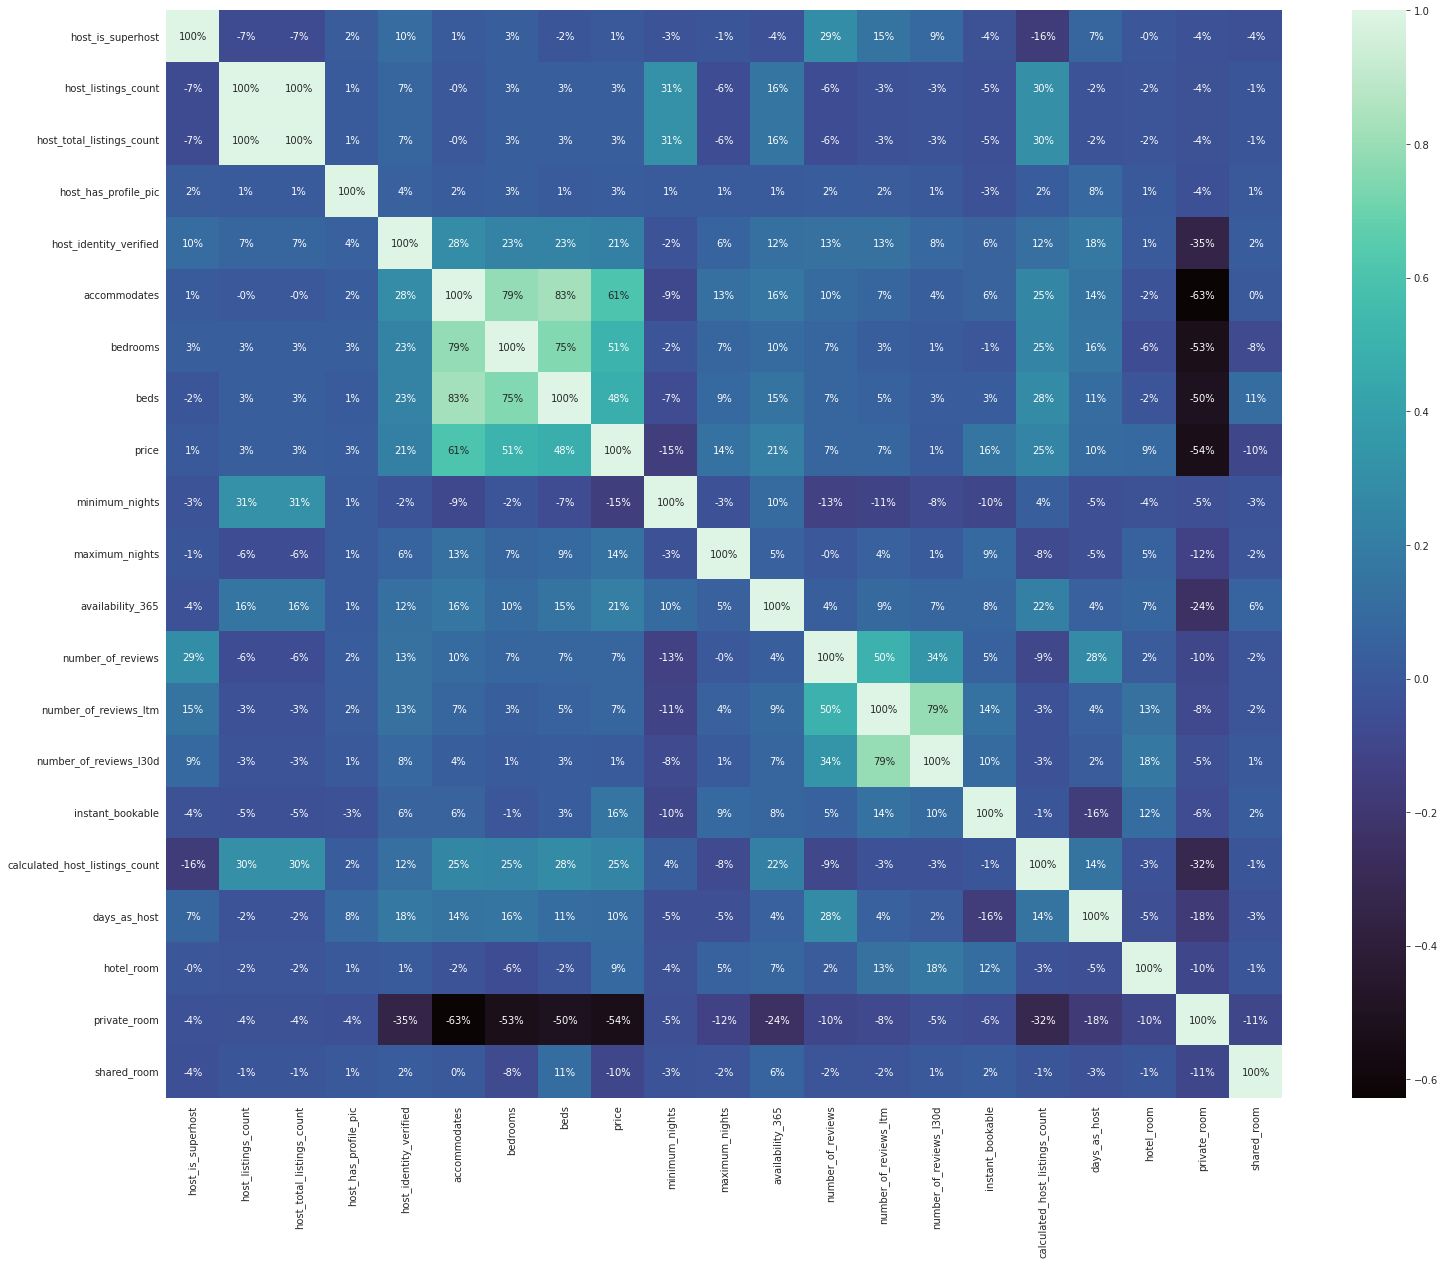

In [ ]:
plt.figure( figsize=(25,20) )
sns.heatmap(data_corr, annot=True, cmap=colors_cmap, fmt='.0%')

In [ ]:
# If passed, data will not be shown in cells where mask is True. Cells with missing values are automatically masked.
data_corr_mask = data_corr.applymap(lambda x: False if abs(x) >= 0.9 else True)

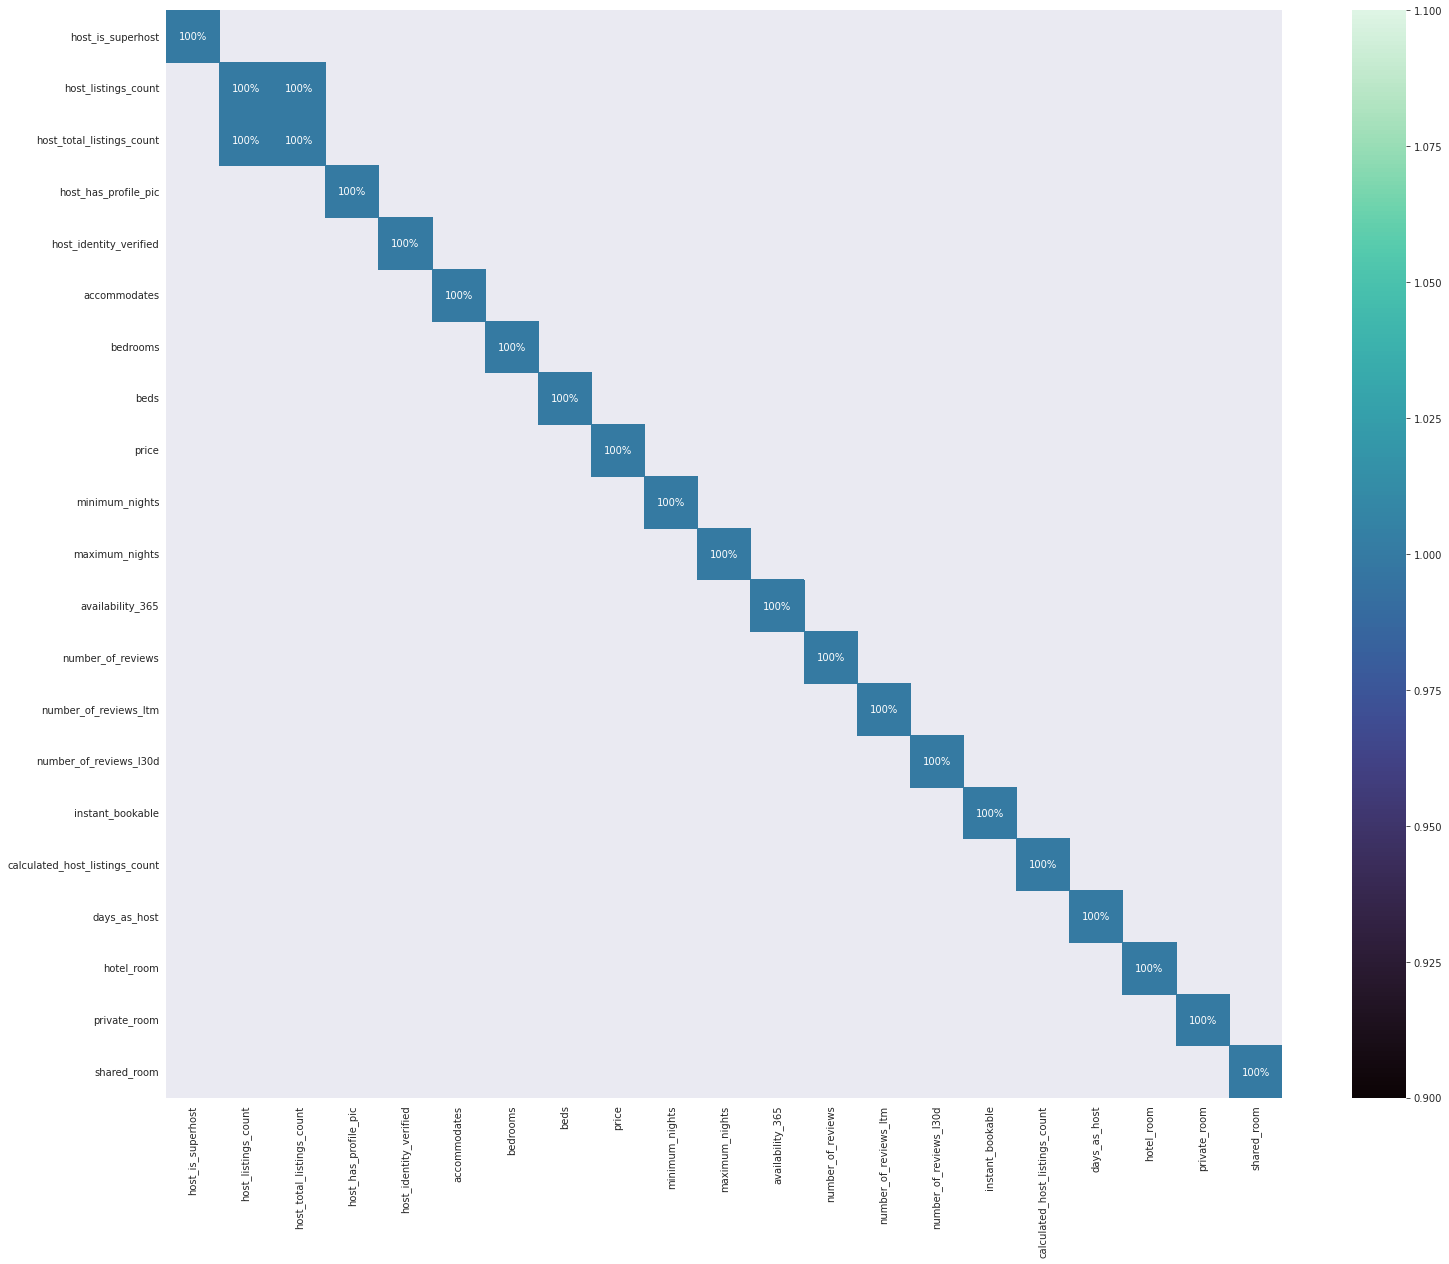

In [ ]:
plt.figure( figsize=(25,20) )
sns.heatmap(data_corr, annot=True, cmap=colors_cmap, mask=data_corr_mask, fmt='.0%')

In [ ]:
data.drop('host_total_listings_count', axis=1, inplace=True)

In [ ]:
res = smf.ols(formula='price ~ accommodates + beds', data=data).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     846.0
Date:                Fri, 14 Jan 2022   Prob (F-statistic):          1.13e-288
Time:                        20:19:12   Log-Likelihood:                -14649.
No. Observations:                2830   AIC:                         2.930e+04
Df Residuals:                    2827   BIC:                         2.932e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       28.0999      1.545     18.191   

In [ ]:
res = smf.ols(formula='price ~ accommodates + beds  + accommodates:beds', data=data).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                     628.7
Date:                Fri, 14 Jan 2022   Prob (F-statistic):          4.95e-313
Time:                        20:19:12   Log-Likelihood:                -14589.
No. Observations:                2830   AIC:                         2.919e+04
Df Residuals:                    2826   BIC:                         2.921e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            11.3497      2.14

In [ ]:
data['accommodates_beds'] = data['accommodates'] * data['beds']

In [ ]:
cols = ['private_room', 'bedrooms','beds', 'accommodates', 'accommodates_beds', 'host_identity_verified',
 'availability_365', 'instant_bookable', 'minimum_nights', 'maximum_nights', 'shared_room', 'number_of_reviews_l30d',
  'host_listings_count', 'calculated_host_listings_count', 'price' ]

In [ ]:
data= data.loc[:, cols]

In [ ]:
X = data.loc[:, data.columns != 'price']
y = data.loc[:,'price']

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2830 entries, 0 to 2999
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   private_room                    2830 non-null   uint8  
 1   bedrooms                        2830 non-null   float64
 2   beds                            2830 non-null   float64
 3   accommodates                    2830 non-null   int64  
 4   accommodates_beds               2830 non-null   float64
 5   host_identity_verified          2830 non-null   int64  
 6   availability_365                2830 non-null   int64  
 7   instant_bookable                2830 non-null   int64  
 8   minimum_nights                  2830 non-null   int64  
 9   maximum_nights                  2830 non-null   int64  
 10  shared_room                     2830 non-null   uint8  
 11  number_of_reviews_l30d          2830 non-null   int64  
 12  host_listings_count             28

In [ ]:
X = add_constant(X)
model_ols = OLS(y, X).fit()
print(model_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.478
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     184.3
Date:                Fri, 14 Jan 2022   Prob (F-statistic):               0.00
Time:                        20:19:12   Log-Likelihood:                -14392.
No. Observations:                2830   AIC:                         2.881e+04
Df Residuals:                    2815   BIC:                         2.890e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

# Test for normal distribution using p-value for each covariate
Confidence Interval = 95% <br />
Two sided test

In [ ]:
cols = data.columns
cols_non_binary = []
for c in cols:
    if data[c].value_counts().shape[0] > 2:
        cols_non_binary.append(c)

In [ ]:
p_values = normaltest(data[cols_non_binary])[1]

In [ ]:
alpha = 0.025
p_values = pd.DataFrame({'coolumns': cols_non_binary, 'p-value': p_values})
p_values['Reject H0'] = np.where(abs(p_values['p-value']) <= alpha, True, False)

In [ ]:
# H0 = Normally Distributed
print("Column Name".ljust(30, " "), "p-value".ljust(10, " "), '  Reject H0?'.rjust(5, " "))
for c,p in zip(cols_non_binary, p_values['p-value'] ):
    print(c.ljust(30, " "), str("{:.3e}".format(p)).ljust(10, " "), '- Reject H0:'.rjust(5, " "), True if p <= alpha else False)

Column Name                    p-value      Reject H0?
bedrooms                       5.059e-244 - Reject H0: True
beds                           1.313e-219 - Reject H0: True
accommodates                   4.416e-141 - Reject H0: True
accommodates_beds              0.000e+00  - Reject H0: True
availability_365               0.000e+00  - Reject H0: True
minimum_nights                 0.000e+00  - Reject H0: True
maximum_nights                 0.000e+00  - Reject H0: True
number_of_reviews_l30d         0.000e+00  - Reject H0: True
host_listings_count            0.000e+00  - Reject H0: True
calculated_host_listings_count 0.000e+00  - Reject H0: True
price                          2.895e-63  - Reject H0: True


In [ ]:
vif_data = pd.DataFrame()
vif_data["feature"] = cols_non_binary
vif_data["VIF"] = [variance_inflation_factor(data[cols_non_binary].values, i) for i in range(len(cols_non_binary))]

In [ ]:
vif_data

,feature,VIF
0,bedrooms,11.882229
1,beds,16.270295
2,accommodates,20.579515
3,accommodates_beds,7.565832
4,availability_365,2.543389
5,minimum_nights,1.348380
6,maximum_nights,2.775795
7,number_of_reviews_l30d,1.068943
8,host_listings_count,1.290561
9,calculated_host_listings_count,1.592635


In [ ]:
rank_matrix = np.linalg.matrix_rank(data.drop(['price'], axis=1))
'Full rank Matrix:' , rank_matrix == data.shape[1]-1

('Full rank Matrix:', True)

In [ ]:
Y = data['price']
X = data.drop(['price'], axis=1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


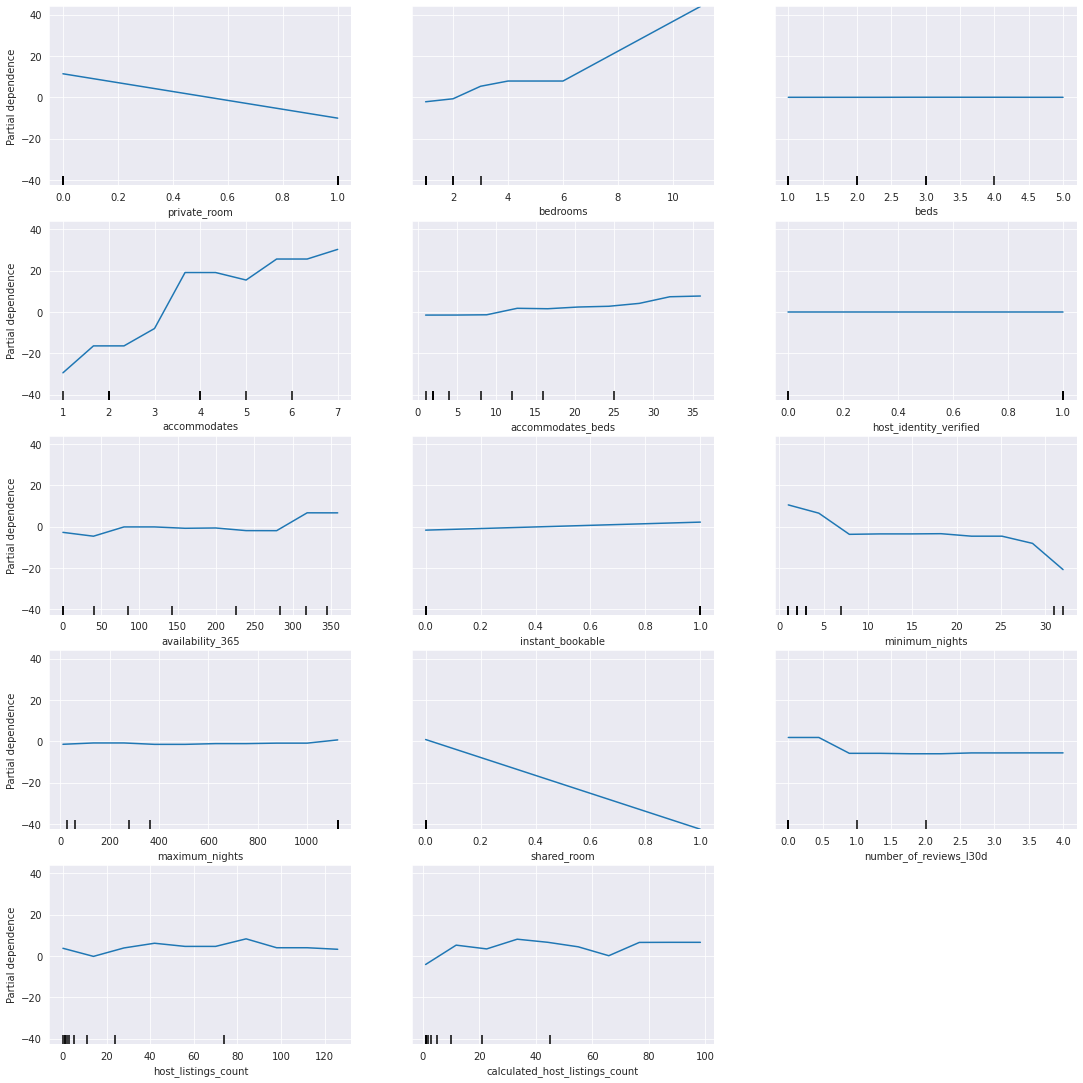

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.inspection import partial_dependence, plot_partial_dependence

cols_to_use = X.columns

from matplotlib.pyplot import figure

fig, ax = plt.subplots(figsize=(15, 15))
fig.tight_layout( )

my_model = GradientBoostingRegressor()
my_model.fit(X, Y)
my_plots = plot_partial_dependence(my_model,
                                   features=[i for i in range(len(X.columns))],
                                   X=X,
                                   feature_names=cols_to_use,
                                   grid_resolution=10,
                                    ax=ax)

In [ ]:
X = add_constant(X)
model_ols = OLS(Y, X).fit()
print(model_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.478
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     184.3
Date:                Fri, 14 Jan 2022   Prob (F-statistic):               0.00
Time:                        20:19:19   Log-Likelihood:                -14392.
No. Observations:                2830   AIC:                         2.881e+04
Df Residuals:                    2815   BIC:                         2.890e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

# Helper Functions

In [ ]:
# helper functions
def adj_r2(shape, r2):
    return 1 - (1-r2) * (shape[0]-1) / (shape[0]-shape[1]-1)


def get_scores(y, y_predict, shape):
    res = []
    metrics = ['Adjusted_R2', 'R2', 'MAE', 'MSE']
    funcs = [r2_score, mean_absolute_error, mean_squared_error]
    for f in funcs:
        res.append(f(y, y_predict))
    res = [adj_r2(shape, res[0])] + res
    return pd.DataFrame([*zip(metrics, res)], columns=['metric', 'result'])

In [ ]:
def cv_plot_results(_model, X_data, Y_data, n_folds=5, epochs=10, use_ax=False):
    cv_mean_errors = []
    _range = range(epochs)
    for _ in _range:
        cv = cross_validate(_model, X_data, Y_data, cv=n_folds)
        adjusted_r2 = [adj_r2( (X_data.shape[0] // n_folds,  X_data.shape[1]) , x) for x in cv['test_score']]
        cv_mean_errors.append( np.mean(adjusted_r2) )

    if not use_ax:
        plt.figure(figsize=(8,8))

    ax = sns.lineplot(y=cv_mean_errors, x=_range, linestyle='--')
    plt.xticks(_range)
    plt.yticks(np.arange(0, 1.02, 0.2))


    if not use_ax:
        plt.title(f'Epochs - Best adjusted R2: {max(cv_mean_errors):.2f}')
        plt.ylabel('Adjusted R2')
        plt.xlabel('Epochs')

        print(f'Best adjusted R2: {max(cv_mean_errors):.2f}')
        plt.show()

    if use_ax:
        return ax, np.mean(cv_mean_errors)

In [ ]:
def cv_plot_multi_models(models, model_titles, X, Y, n_folds=5, epochs=10, use_ax=False):
    n = len(models)
    fig, axs = plt.subplots(1, n, figsize=(n*5,5))
    results = []
    for i in range(n):
        ax = plt.subplot(1,n,i+1)
        plt.title(model_titles[i])
        ax, s = cv_plot_results(models[i], X, Y, n_folds=n_folds, epochs=epochs, use_ax=True)
        results.append(s)

    for r, m in zip(results, model_titles):
        print(f'Best adjusted R2: {m.rjust(20," ")} = {r:.4f}')

    plt.show()

# Split into train and test

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

In [ ]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((2264, 15), (566, 15), (2264,), (566,))

In [ ]:
# x_train = add_constant(x_train)
model_ols = OLS(y_train, x_train).fit()

In [ ]:
y_predict = model_ols.predict(x_test)

In [ ]:
get_scores(y_test, y_predict, x_test.shape)

,metric,result
0,Adjusted_R2,0.444138
1,R2,0.458896
2,MAE,29.480059
3,MSE,1480.993726


In [ ]:
scaled_price = data[['price']].copy()

scaled_price['StandardScaler'] = StandardScaler().fit_transform(scaled_price[['price']])
scaled_price['MinMaxScaler'] = MinMaxScaler().fit_transform(scaled_price[['price']])
scaled_price['Normalizer'] = Normalizer().fit_transform(scaled_price[['price']])

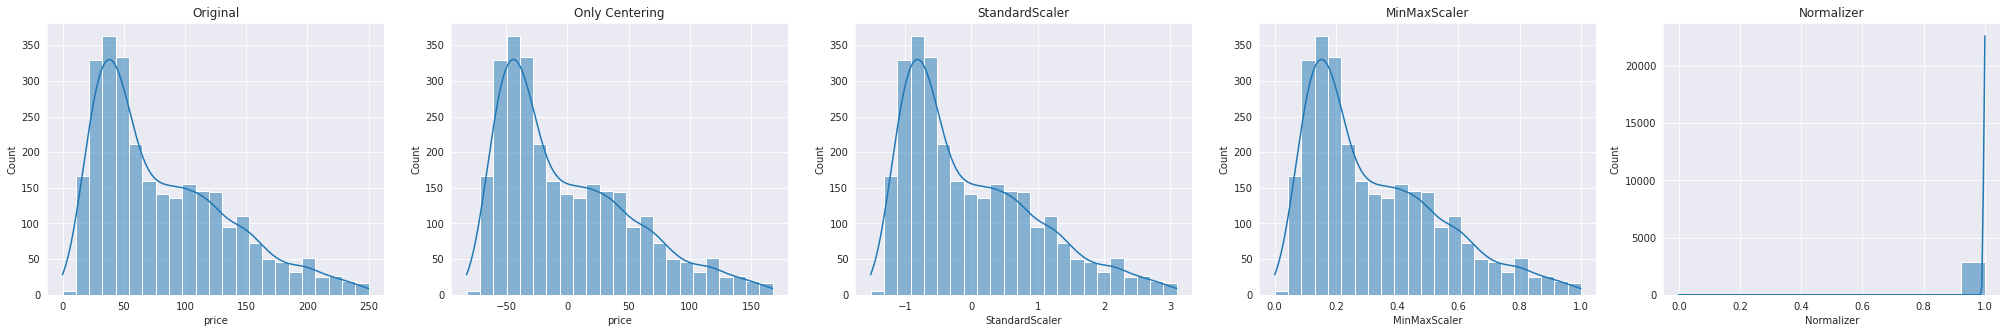

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(5*7, 5))
ax = plt.subplot(1, 5, 1)
plt.title("Original")
ax = sns.histplot(scaled_price['price'], kde=True)
ax = plt.subplot(1, 5, 2)
plt.title("Only Centering")
ax = sns.histplot(scaled_price['price'] - scaled_price['price'].mean(), kde=True)
ax = plt.subplot(1, 5, 3)
plt.title("StandardScaler")
ax = sns.histplot(scaled_price['StandardScaler'], kde=True)
ax = plt.subplot(1, 5, 4)
plt.title("MinMaxScaler")
ax = sns.histplot(scaled_price['MinMaxScaler'], kde=True)
ax = plt.subplot(1, 5, 5)
plt.title("Normalizer")
ax = sns.histplot(scaled_price['Normalizer'], kde=True)
plt.show()

# Models

## OLS models

In [ ]:
scaler = StandardScaler()

scaled_data = pd.DataFrame( scaler.fit_transform(data), columns=data.columns)

X = scaled_data.drop(['price'], axis=1)
Y = scaled_data['price']

model = LinearRegression()

params = {
    'fit_intercept': [True, False]
}

grid_search = GridSearchCV(model, param_grid=params, cv=5, n_jobs=-1)
grid_search.fit(X, Y)


print(f"Best Score achived: {np.round(grid_search.best_score_, 3)}")
print(f"with this parameters: {grid_search.best_params_}")

Best Score achived: 0.46
with this parameters: {'fit_intercept': False}


In [ ]:
scaler = MinMaxScaler()

scaled_data = pd.DataFrame( scaler.fit_transform(data), columns=data.columns)

X = scaled_data.drop(['price'], axis=1)
Y = scaled_data['price']

model = LinearRegression()

params = {
    'fit_intercept': [True, False]
}

grid_search = GridSearchCV(model, param_grid=params, cv=5, n_jobs=-1)
grid_search.fit(X, Y)


print(f"Best Score achived: {np.round(grid_search.best_score_, 3)}")
print(f"with this parameters: {grid_search.best_params_}")

Best Score achived: 0.46
with this parameters: {'fit_intercept': True}


In [ ]:
scaler = Normalizer()

scaled_data = pd.DataFrame( scaler.fit_transform(data), columns=data.columns)

X = scaled_data.drop(['price'], axis=1)
Y = scaled_data['price']

model = LinearRegression()

params = {
    'fit_intercept': [True, False]
}

grid_search = GridSearchCV(model, param_grid=params, cv=5, n_jobs=-1)
grid_search.fit(X, Y)


print(f"Best Score achived: {np.round(grid_search.best_score_, 3)}")
print(f"with this parameters: {grid_search.best_params_}")

Best Score achived: 0.846
with this parameters: {'fit_intercept': True}


## Ridg regression models

In [ ]:
scaler = StandardScaler()

scaled_data = pd.DataFrame( scaler.fit_transform(data), columns=data.columns)

X = scaled_data.drop(['price'], axis=1)
Y = scaled_data['price']

model = Ridge()

params = {
    'alpha': [ _ for _ in np.arange(0.05, 1.001, 0.005)],
    'fit_intercept': [True, False]
}

grid_search = GridSearchCV(model, param_grid=params, n_jobs=-1)
grid_search.fit(X, Y)

print(f"Best Score achived: {np.round(grid_search.best_score_, 3)}")
print(f"with this parameters: {grid_search.best_params_}")

Best Score achived: 0.46
with this parameters: {'alpha': 0.9999999999999996, 'fit_intercept': False}


In [ ]:
scaler = MinMaxScaler()

scaled_data = pd.DataFrame( scaler.fit_transform(data), columns=data.columns)

X = scaled_data.drop(['price'], axis=1)
Y = scaled_data['price']

model = Ridge()

params = {
    'alpha': [ _ for _ in np.arange(0.05, 1.001, 0.005)],
    'fit_intercept': [True, False]
}

grid_search = GridSearchCV(model, param_grid=params, n_jobs=-1)
grid_search.fit(X, Y)

print(f"Best Score achived: {np.round(grid_search.best_score_, 3)}")
print(f"with this parameters: {grid_search.best_params_}")

Best Score achived: 0.467
with this parameters: {'alpha': 0.6199999999999998, 'fit_intercept': True}


In [ ]:
scaler = Normalizer()

scaled_data = pd.DataFrame( scaler.fit_transform(data), columns=data.columns)

X = scaled_data.drop(['price'], axis=1)
Y = scaled_data['price']

model = Ridge()

params = {
    'alpha': [ _ for _ in np.arange(0.05, 1.001, 0.005)],
    'fit_intercept': [True, False]
}

grid_search = GridSearchCV(model, param_grid=params, n_jobs=-1)
grid_search.fit(X, Y)

print(f"Best Score achived: {np.round(grid_search.best_score_, 3)}")
print(f"with this parameters: {grid_search.best_params_}")

Best Score achived: 0.839
with this parameters: {'alpha': 0.05, 'fit_intercept': True}


## Lasso regression models

In [ ]:
scaler = StandardScaler()

scaled_data = pd.DataFrame( scaler.fit_transform(data), columns=data.columns)

X = scaled_data.drop(['price'], axis=1)
Y = scaled_data['price']

model = Lasso()

params = {
    'alpha': [ _ for _ in np.arange(0.05, 1.001, 0.005)],
    'fit_intercept': [True, False]
}

grid_search = GridSearchCV(model, param_grid=params, n_jobs=-1)
grid_search.fit(X, Y)

print(f"Best Score achived: {np.round(grid_search.best_score_, 3)}")
print(f"with this parameters: {grid_search.best_params_}")

Best Score achived: 0.448
with this parameters: {'alpha': 0.05, 'fit_intercept': False}


In [ ]:
scaler = MinMaxScaler()

scaled_data = pd.DataFrame( scaler.fit_transform(data), columns=data.columns)

X = scaled_data.drop(['price'], axis=1)
Y = scaled_data['price']

model = Lasso()

params = {
    'alpha': [ _ for _ in np.arange(0.05, 1.001, 0.005)],
    'fit_intercept': [True, False]
}

grid_search = GridSearchCV(model, param_grid=params, n_jobs=-1)
grid_search.fit(X, Y)

print(f"Best Score achived: {np.round(grid_search.best_score_, 3)}")
print(f"with this parameters: {grid_search.best_params_}")

Best Score achived: 0.073
with this parameters: {'alpha': 0.05, 'fit_intercept': True}


In [ ]:
scaler = Normalizer()

scaled_data = pd.DataFrame( scaler.fit_transform(data), columns=data.columns)

X = scaled_data.drop(['price'], axis=1)
Y = scaled_data['price']

model = Lasso()

params = {
    'alpha': [ _ for _ in np.arange(0.05, 1.001, 0.005)],
    'fit_intercept': [True, False]
}

grid_search = GridSearchCV(model, param_grid=params, n_jobs=-1)
grid_search.fit(X, Y)

print(f"Best Score achived: {np.round(grid_search.best_score_, 3)}")
print(f"with this parameters: {grid_search.best_params_}")

Best Score achived: 0.112
with this parameters: {'alpha': 0.05, 'fit_intercept': True}


## Decision Tree Regression

In [ ]:
scaler = StandardScaler()

scaled_data = pd.DataFrame( scaler.fit_transform(data), columns=data.columns)

X = scaled_data.drop(['price'], axis=1)
Y = scaled_data['price']

model = DecisionTreeRegressor()

params = {
    'max_depth': [100, 200, 500],
    'min_samples_leaf': [3, 5]
}

grid_search = GridSearchCV(model, param_grid=params, cv=5, n_jobs=-1)
grid_search.fit(X, Y)


print(f"Best Score achived: {np.round(grid_search.best_score_, 3)}")
print(f"with this parameters: {grid_search.best_params_}")

Best Score achived: 0.471
with this parameters: {'max_depth': 500, 'min_samples_leaf': 5}


In [ ]:
scaler = MinMaxScaler()

scaled_data = pd.DataFrame( scaler.fit_transform(data), columns=data.columns)

X = scaled_data.drop(['price'], axis=1)
Y = scaled_data['price']

model = DecisionTreeRegressor()

params = {
    'max_depth': [100, 200, 500],
    'min_samples_leaf': [3, 5]
}

grid_search = GridSearchCV(model, param_grid=params, cv=5, n_jobs=-1)
grid_search.fit(X, Y)


print(f"Best Score achived: {np.round(grid_search.best_score_, 3)}")
print(f"with this parameters: {grid_search.best_params_}")

Best Score achived: 0.474
with this parameters: {'max_depth': 100, 'min_samples_leaf': 5}


In [ ]:
scaler = Normalizer()

scaled_data = pd.DataFrame( scaler.fit_transform(data), columns=data.columns)

X = scaled_data.drop(['price'], axis=1)
Y = scaled_data['price']

model = DecisionTreeRegressor()

params = {
    'max_depth': [100, 200, 500],
    'min_samples_leaf': [3, 5]
}

grid_search = GridSearchCV(model, param_grid=params, cv=5, n_jobs=-1)
grid_search.fit(X, Y)


print(f"Best Score achived: {np.round(grid_search.best_score_, 3)}")
print(f"with this parameters: {grid_search.best_params_}")

Best Score achived: 0.934
with this parameters: {'max_depth': 100, 'min_samples_leaf': 5}


## Random Forest Regression

In [ ]:
scaler = StandardScaler()

scaled_data = pd.DataFrame( scaler.fit_transform(data), columns=data.columns)

X = scaled_data.drop(['price'], axis=1)
Y = scaled_data['price']

model = RandomForestRegressor()

params = {
    'n_estimators': [150, 200],
    'max_depth': [100, 200, 500],
    'min_samples_leaf': [3, 5]
}

grid_search = GridSearchCV(model, param_grid=params, cv=5, n_jobs=-1)
grid_search.fit(X, Y)


print(f"Best Score achived: {np.round(grid_search.best_score_, 3)}")
print(f"with this parameters: {grid_search.best_params_}")

Best Score achived: 0.593
with this parameters: {'max_depth': 500, 'min_samples_leaf': 3, 'n_estimators': 200}


In [ ]:
scaler = MinMaxScaler()

scaled_data = pd.DataFrame( scaler.fit_transform(data), columns=data.columns)

X = scaled_data.drop(['price'], axis=1)
Y = scaled_data['price']

model = RandomForestRegressor()

params = {
    'n_estimators': [150, 200],
    'max_depth': [100, 200, 500],
    'min_samples_leaf': [3, 5]
}

grid_search = GridSearchCV(model, param_grid=params, cv=5, n_jobs=-1)
grid_search.fit(X, Y)


print(f"Best Score achived: {np.round(grid_search.best_score_, 3)}")
print(f"with this parameters: {grid_search.best_params_}")

Best Score achived: 0.594
with this parameters: {'max_depth': 500, 'min_samples_leaf': 3, 'n_estimators': 200}


In [ ]:
scaler = Normalizer()

scaled_data = pd.DataFrame( scaler.fit_transform(data), columns=data.columns)

X = scaled_data.drop(['price'], axis=1)
Y = scaled_data['price']

model = RandomForestRegressor()

params = {
    'n_estimators': [150, 200],
    'max_depth': [100, 200, 500],
    'min_samples_leaf': [3, 5]
}

grid_search = GridSearchCV(model, param_grid=params, cv=5, n_jobs=-1)
grid_search.fit(X, Y)


print(f"Best Score achived: {np.round(grid_search.best_score_, 3)}")
print(f"with this parameters: {grid_search.best_params_}")

Best Score achived: 0.953
with this parameters: {'max_depth': 200, 'min_samples_leaf': 3, 'n_estimators': 200}


## PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()
data_pca = pca.fit_transform(data.drop(['price'], axis=1))
data_pca = pd.DataFrame(data_pca, columns=[f'pc_{i}' for i in range(data_pca.shape[1])])

In [ ]:
num_cols = 4
pca.explained_variance_ratio_[:num_cols].sum()

0.9964569690444356

In [ ]:
rank_matrix = np.linalg.matrix_rank(data_pca.iloc[:, :num_cols])
'Full rank Matrix:' , rank_matrix == num_cols

('Full rank Matrix:', True)

Best adjusted R2: 0.13


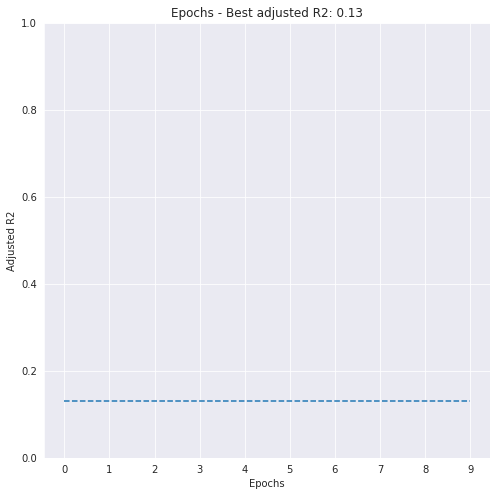

In [ ]:
lm = LinearRegression()
cv_plot_results(lm, data_pca.iloc[:, :num_cols], data['price'])